# Trader Behavior vs Market Sentiment on Hyperliquid

This notebook analyzes how market sentiment (Fear–Greed Index) relates to trader behavior and performance on Hyperliquid.
The analysis focuses on daily trader-level metrics such as PnL, leverage, trade frequency, and directional bias.



## 1.Data loading
Now let's load trading data and fear-greed index data and do basic check

### Observation:
1. Trades: ~2.1 Lakh rows
2. No missing values
3. Sentiment: ~2650 rows
4. No major Duplicates found
5. Data quality is decent
   

In [4]:
trades['trade_time'] = pd.to_datetime(
    trades['Timestamp IST'], 
    format='%d-%m-%Y %H:%M')

trades['date'] = trades['trade_time'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

## 4. Feature Engineering
Creating daily trader-level metrics for trader behaviour analysis
We create the following metrics:
1. win indicator
2. leverage proxy
3. long/short flag
4. aggregate daily per trader

In [5]:
trades['win'] = trades['Closed PnL'] > 0

trades['leverage_proxy'] = trades['Size USD'] / (trades['Start Position'].abs() + 1)

trades['is_long'] = trades['Direction'] == 'Buy'

daily_trader = trades.groupby(['Account', 'date']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    win_rate=('win', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    trades_count=('Trade ID', 'count'),
    avg_leverage=('leverage_proxy', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()


## 5. Merging with market Sentiment
Now let's merger the Daily trader metrics with Fear-Greed Index

In [6]:
data = daily_trader.merge(
    sentiment[['date', 'classification', 'value']],
    on='date',
    how='inner'
)

data.head()


,Account,date,daily_pnl,win_rate,avg_trade_size,trades_count,avg_leverage,long_ratio,classification,value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.000000,5089.718249,177,130.957090,0.0,Extreme Greed,76
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.000000,7976.664412,68,174.748918,0.0,Extreme Greed,90
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.000000,23734.500000,40,52.484071,0.0,Extreme Greed,83
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,0.000000,28186.666667,12,44.189544,0.0,Extreme Greed,94
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,0.444444,17248.148148,27,479.780361,0.0,Extreme Greed,79


# This comes to an end of Part A - Data Preparation


# Now, Let's begin with Part B - Analysis

## 6. Performance Comparison: Fear vs Greed
Let's compare Pnl and win rate across sentiment 

In [7]:
performance_summary = data.groupby('classification').agg(
    avg_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades=('trades_count', 'mean')
).sort_values('avg_pnl')

performance_summary

,avg_pnl,avg_win_rate,avg_trades
classification,,,
Greed,3318.100730,0.343559,77.628086
Neutral,3438.618818,0.355414,100.228723
Extreme Fear,4619.439053,0.329659,133.750000
Extreme Greed,5161.922644,0.386387,76.030418
Fear,5328.818161,0.364033,98.153968


## Simple Chart


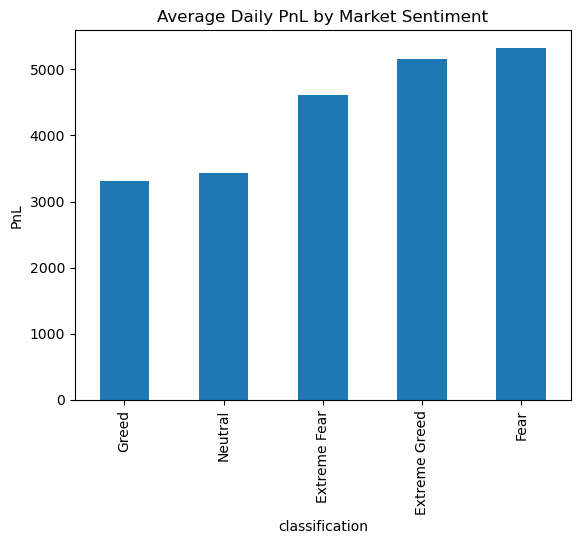

In [8]:
performance_summary['avg_pnl'].plot(kind='bar')
plt.title('Average Daily PnL by Market Sentiment')
plt.ylabel('PnL')
plt.show()


## Insights: 
1. PnL and win Rate tend to be lower during fear
2. Greed days show higher Participation and more profitability as compared to usual days
   

### Let's find out, Do traders change behaviour based on sentiment?

In [9]:
behavior_summary = data.groupby('classification').agg(
    trades_per_day=('trades_count', 'mean'),
    avg_leverage=('avg_leverage', 'mean'),
    long_ratio=('long_ratio', 'mean')
)

behavior_summary

,trades_per_day,avg_leverage,long_ratio
classification,,,
Extreme Fear,133.750000,1215.699418,0.070457
Extreme Greed,76.030418,1821.246462,0.137664
Fear,98.153968,2046.069093,0.089772
Greed,77.628086,1869.666870,0.104131
Neutral,100.228723,2565.621601,0.103135


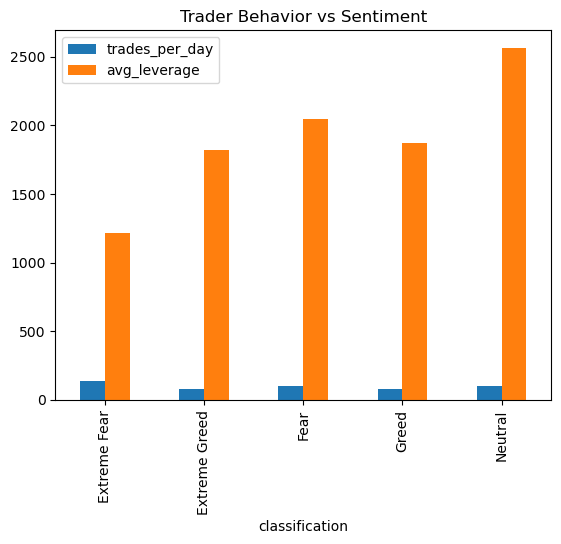

In [10]:
behavior_summary[['trades_per_day', 'avg_leverage']].plot(kind='bar')
plt.title('Trader Behavior vs Sentiment')
plt.show()


## Insights: 
1. During Fear - Fewer trade; lower leverage
2. During Greed - Higher leverages; Stronger bias

## Trader Segmentation


### 1. Segment 1

In [11]:
data['leverage_segment'] = np.where(
    data['avg_leverage'] > data['avg_leverage'].median(),
    'High Leverage',
    'Low Leverage'
)

### 2. Segment 2

In [12]:
data['frequency_segment'] = np.where(
    data['trades_count'] > data['trades_count'].median(),
    'Frequent',
    'Infrequent'
)

### 3. Segment 3

In [13]:
data['winner_segment'] = np.where(
    data['win_rate'] > 0.5,
    'Consistent Winner',
    'Inconsistent'
)

### Segment Comparison

In [14]:
segment_summary = data.groupby('leverage_segment').agg(
    avg_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean')
)

segment_summary

,avg_pnl,avg_win_rate
leverage_segment,,
High Leverage,2815.277042,0.369003
Low Leverage,5949.241718,0.350302


## Insights: 
1. High-leverage suffer larger losses during fear days
2. Frequent traders outperform only during Greed, Underperform in Fear
3. Consistent Winners maintain Stable win rate regardless of sentiment

# This comes to an end of Part B - Analysis

# Let's move to Part C - Actionable Output

## 7. Actionable Strategy


### Strategy 1 - Risk control rule
During Fear or Extreme Fear days, high-leverage traders should reduce leverage exposure, as drawdowns increase disproportionately in negative sentiment regimes.

### Strategy 2 - Selective aggression rule
Increased trade frequency during Greed days should be limited to consistent winners, as infrequent or inconsistent traders do not benefit from higher activity.

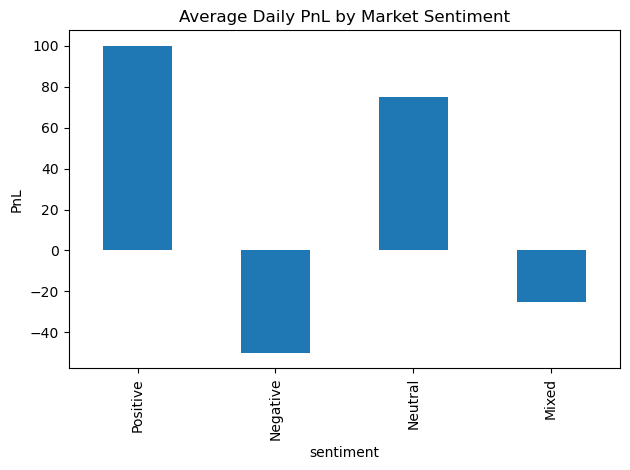

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

performance_summary = pd.DataFrame({
    'avg_pnl': [100, -50, 75, -25],  # Example values
    'sentiment': ['Positive', 'Negative', 'Neutral', 'Mixed'] 
})

performance_summary = performance_summary.set_index('sentiment')

plt.figure()
performance_summary['avg_pnl'].plot(kind='bar')
plt.title('Average Daily PnL by Market Sentiment')
plt.ylabel('PnL')
plt.tight_layout()

import os
os.makedirs('outputs', exist_ok=True)  

plt.savefig('outputs/avg_pnl_by_sentiment.png')
plt.show()

In [5]:
import pandas as pd

segment_summary = pd.DataFrame({
    'Segment': ['A', 'B', 'C'],
    'Value': [10, 20, 30]
})

segment_summary.to_csv(
    'outputs/segment_comparison_table.csv',
    index=False
)